In [1]:
from google.colab import drive
drive.mount('drive', force_remount = True)

Mounted at drive


In [0]:
!ls "drive/My Drive/kaggle"

In [0]:
from zipfile import ZipFile
from io import BytesIO
from PIL import Image
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2


In [0]:
root_path = 'drive/My Drive/kaggle/'

In [8]:
train_labels = pd.read_csv(root_path + 'data/human_protein/train.csv')
train_labels.head(20)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7


In [0]:
'''Create label dictionary'''
label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

'''Inverse of label dictionary'''
inverse_label_dict = {k:v for v,k in label_dict.items()}

Convert labels to one-hot encoding

In [0]:
'''
function that will be applied to each row
+ input parameter is row of dataframe
'''
def split_target(row):
  # Split content of target field, which is labels of image
  row.Target = np.array(row.Target.split(' ')).astype(np.int)
  
  # Add field to existing dataframe
  for label_num in row.Target:
    field_name = label_dict[label_num]
    row.loc[field_name] = 1  # mark the class as 1
  return row

In [0]:
'''Set all field label to 0 first'''
for key in label_dict.keys():
    train_labels[label_dict[key]] = 0

In [0]:
'''Apply to existing dataframe'''
train_labels = train_labels.apply(split_target, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


###Histogram of images

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


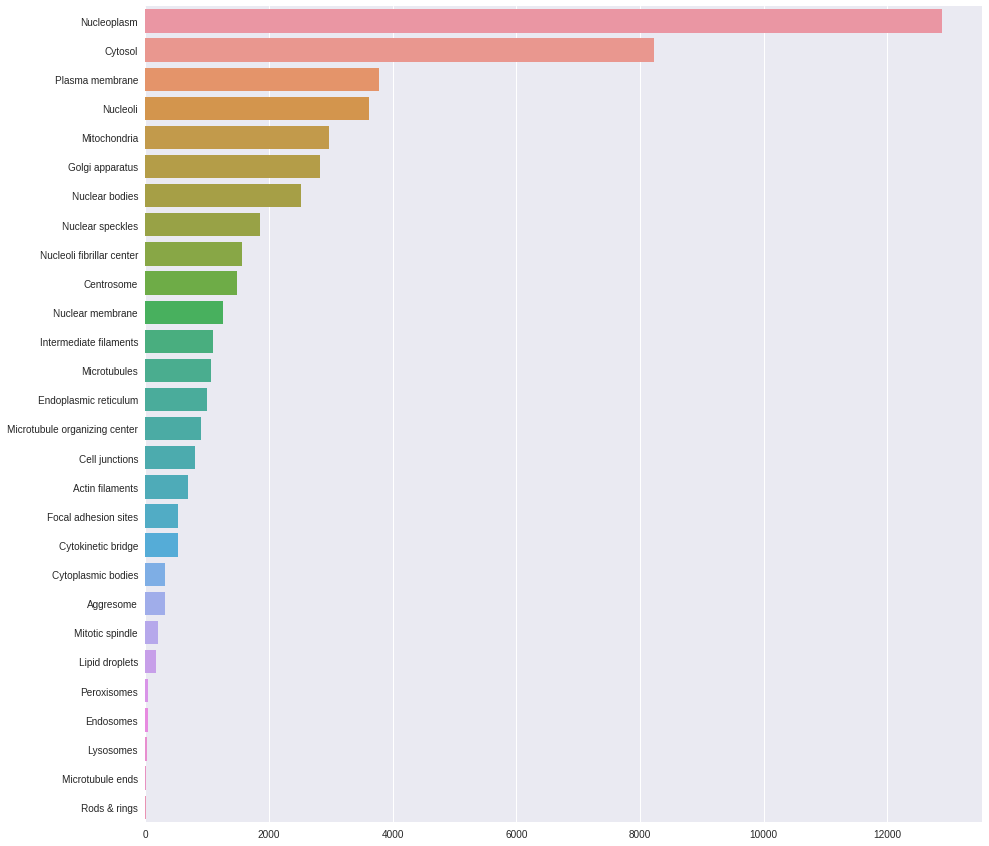

In [0]:
images_count = train_labels.drop(['Id', 'Target'], axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=images_count.index.values, x=images_count.values, order=images_count.index)

###Histogram of number of labels per image

In [0]:
'''Add number of labels for each row'''
train_labels['number_of_labels'] = train_labels.drop(['Id', 'Target'], axis=1).sum(axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'% of images')

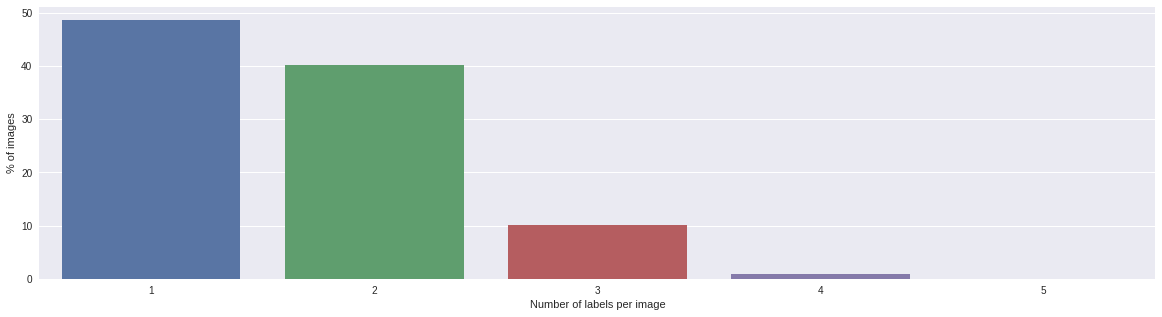

In [0]:

# Calculate percentage
nb_labels_percentage = np.round(100 *(train_labels['number_of_labels'].value_counts() / train_labels.shape[0]), 2)
plt.figure(figsize=(20,5))
sns.barplot(x=nb_labels_percentage.index.values, y=nb_labels_percentage.values)
plt.xlabel('Number of labels per image')
plt.ylabel('% of images')

###Correlation between human proteins

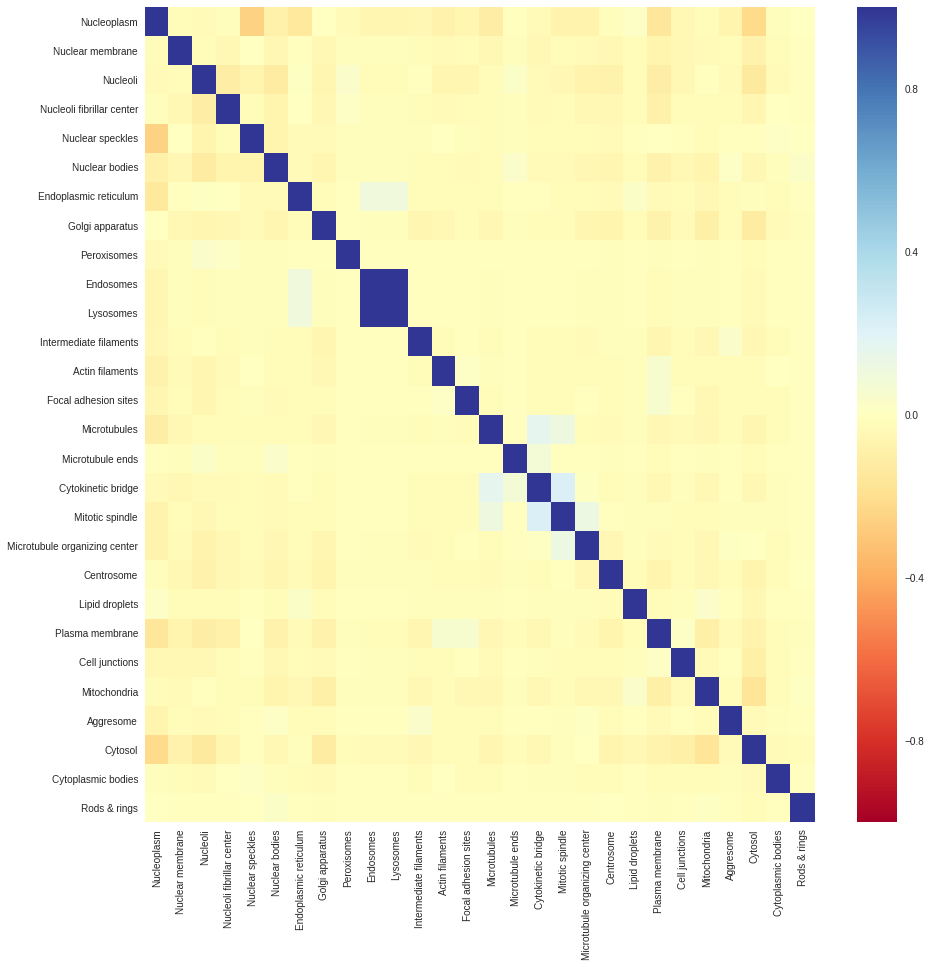

In [0]:
plt.figure(figsize=(15,15))
sns.heatmap(train_labels[train_labels.number_of_labels>1].drop(['Id', 'Target', 'number_of_labels'], axis=1).corr(),
           cmap='RdYlBu', vmin=-1, vmax=1)

##Visualize some images

In [0]:
'''read from zip file'''
files = ZipFile('drive/My Drive/kaggle/data/human_protein/all.zip', 'r')

In [0]:
'''read from zip file'''
zip_files = ZipFile('drive/My Drive/kaggle/data/human_protein/train_2/train.zip')
train_zip_files = zip_files.namelist()
train_zip_files

In [0]:
''' get all images from /train, image is stacked by RGB or yellow-blue'''

def get_images(zipfiles, files):
  images = []

  for f in files:
    red_filter = f + '_red.png'
    green_filter = f + '_green.png'
    blue_filter = f + '_blue.png'
    yellow_filter = f + '_yellow.png'

    red = np.array(Image.open(BytesIO(zipfiles.open(red_filter).read())).convert("L"))
    green = np.array(Image.open(BytesIO(zipfiles.open(green_filter).read())).convert("L"))
    blue = np.array(Image.open(BytesIO(zipfiles.open(blue_filter).read())).convert("L"))
    yellow = np.array(Image.open(BytesIO(zipfiles.open(yellow_filter).read())).convert("L"))

    rgb=Image.fromarray(np.concatenate((np.expand_dims(red,axis=2),np.expand_dims(green,axis=2),np.expand_dims(blue,axis=2)),axis=2))
  #   y=Image.fromarray(np.concatenate((np.expand_dims(yellow,axis=2),np.expand_dims(yellow,axis=2),np.expand_dims(blue,axis=2)),axis=2))
    y=Image.fromarray(np.concatenate((np.expand_dims(yellow,axis=2),np.expand_dims(yellow,axis=2),np.expand_dims(blue,axis=2)),axis=2))

    images.append(rgb)
  return images


In [0]:

def plot_images(from_index, to_index, csv_files, file_col, label_col, label_dict, zipfiles, plot_mode='list', rows=None, cols=None):
  '''
  Plot image from specific slice
  ------------------------------------------
  Parameters:
  + from_index: int, start index in csv file
  + to_index: int, end index in csv fike
  + file_col: int, column index that store filename
  + label_col: int, column index that store original label (id)
  + label_dict: dictionary label which keys are individual id and values are text labels
  + zipfile: zip file contains images
  ------------------------------------------
  
  '''
  
  
  origin_labels = csv_files[csv_files.columns[label_col]]
  files = csv_files[csv_files.columns[file_col]]
  labels = []
  # Convert origin labels to text labels
  for olabel in origin_labels[from_index:to_index]:
    temp = []
    for i in olabel.split(' '):
      temp.append(label_dict[int(i)])
    labels.append(temp)
    
  images = get_images(zipfiles, files[from_index:to_index])
  
  
  if plot_mode == 'list':
    for i in range(len(files[from_index:to_index])):
      plot_label = ''
      for l in labels[i]:

        plot_label += (l + ' - ')

      plt.figure(figsize=(15,15))
      plt.title(plot_label)
      plt.imshow(images[i])
      plt.axis('off')
  elif plot_mode == 'grid':
    fig = plt.figure(figsize=(30,30))
    for i in range(len(files[from_index:to_index])):
      plot_label = ''
      for l in labels[i]:
        plot_label += (l + ' - ')
      fig.add_subplot(rows, cols, i + 1)
      plt.title(plot_label)
      plt.axis('off')
      plt.imshow(images[i])
      
      

###Image when using RGB channels

(-0.5, 511.5, 511.5, -0.5)

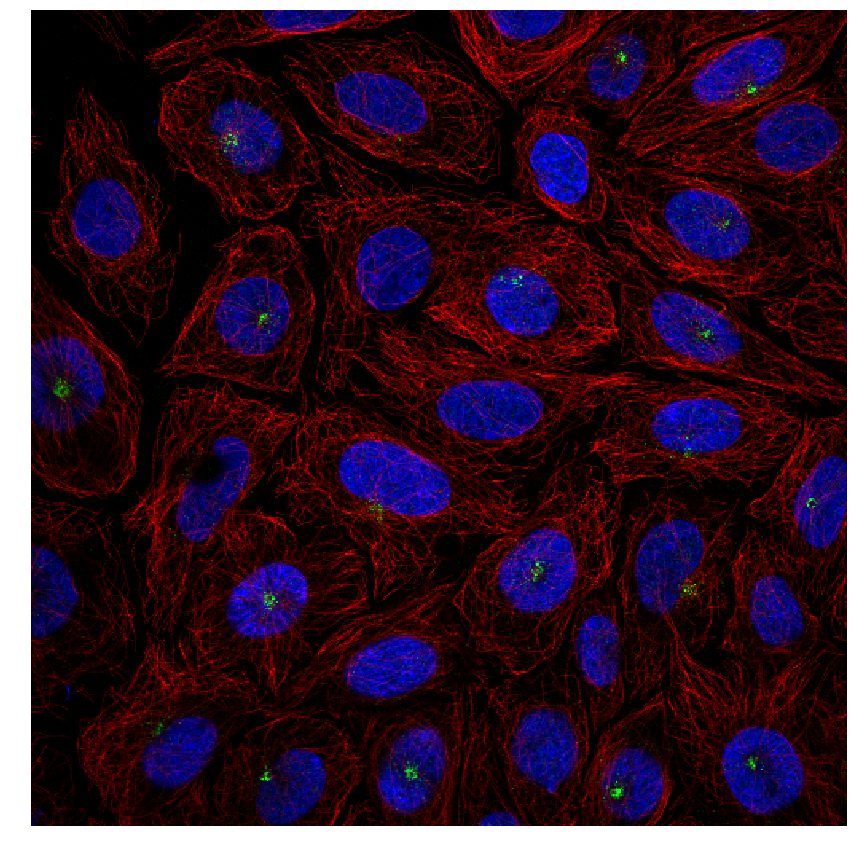

In [53]:
plt.figure(figsize=(15,15))
plt.imshow(images[4])
plt.axis('off')

###Image when using yellow-blue channels

(-0.5, 511.5, 511.5, -0.5)

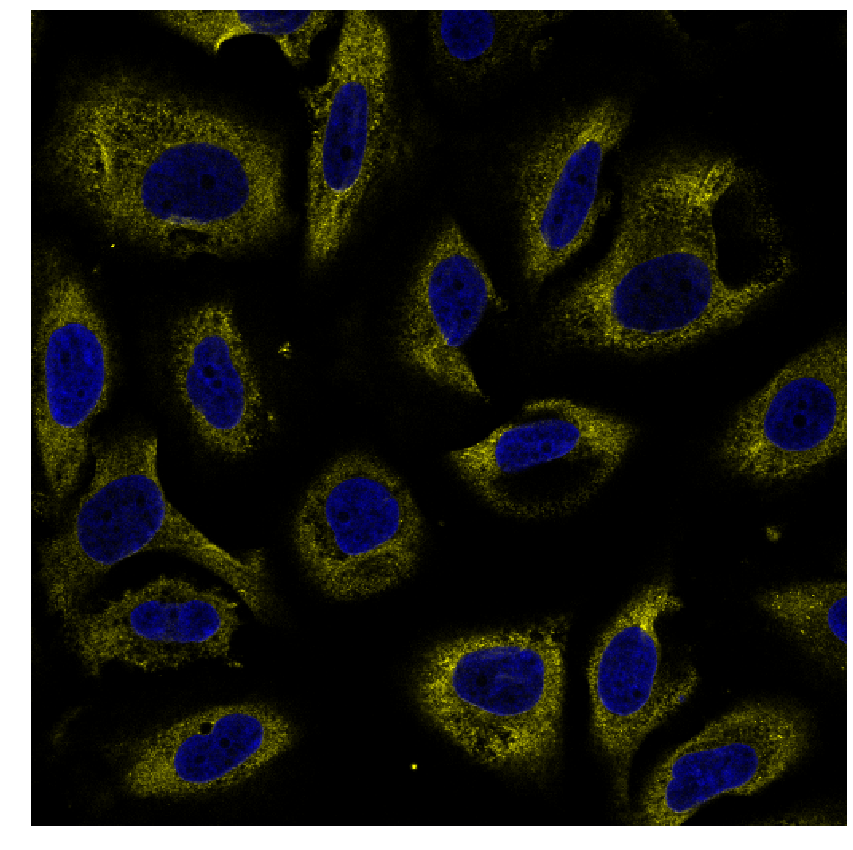

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(images[1])
plt.axis('off')

Get represent image from each class

In [122]:
''' get indices and represent label for each class '''
indices = []
pres_labels = []
for i in range(28):
#   print(i)
  index = (np.where(labels == str(i))[0])
  if len(index) > 0:
    indices.append(index[0])
    pres_labels.append(label_dict[i])
  else:
    print('--> miss: ', label_dict[i], i)
pres_labels

--> miss:  Lysosomes 10
--> miss:  Microtubule ends 15
--> miss:  Mitotic spindle 17


['Nucleoplasm',
 'Nuclear membrane',
 'Nucleoli',
 'Nucleoli fibrillar center',
 'Nuclear speckles',
 'Nuclear bodies',
 'Endoplasmic reticulum',
 'Golgi apparatus',
 'Peroxisomes',
 'Endosomes',
 'Intermediate filaments',
 'Actin filaments',
 'Focal adhesion sites',
 'Microtubules',
 'Cytokinetic bridge',
 'Microtubule organizing center',
 'Centrosome',
 'Lipid droplets',
 'Plasma membrane',
 'Cell junctions',
 'Mitochondria',
 'Aggresome',
 'Cytosol',
 'Cytoplasmic bodies',
 'Rods & rings']

In [0]:
''' get images files from csv'''
pres_image_files = []
for i in indices:
  pres_image_files.append(train_files[i])
pres_image_files

In [0]:
''' get images (stack 3 channels of images - RGB) '''
pres_images = get_images(zip_files, pres_image_files)

###Images from individual class

In [104]:
''' plot images '''
for i in range(len(pres_labels)):
  plt.figure(figsize=(15,15))
  plt.title(pres_labels[i])
  plt.imshow(pres_images[i])
  plt.axis('off')

###Images from specific slice in train files

In [24]:
plot_images(0, 5, train_labels, 0, 1, label_dict, zip_files)

In [36]:
plot_images(0, 25, train_labels, 0, 1, label_dict, zip_files, plot_mode='grid', rows=5, cols=5)

In [37]:
plot_images(25, 50, train_labels, 0, 1, label_dict, zip_files, plot_mode='grid', rows=5, cols=5)

In [38]:
plot_images(50, 75, train_labels, 0, 1, label_dict, zip_files, plot_mode='grid', rows=5, cols=5)

In [39]:
plot_images(75, 100, train_labels, 0, 1, label_dict, zip_files, plot_mode='grid', rows=5, cols=5)